# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [2]:
import neuro_op as nop
import matplotlib.pyplot as plt

# import networkx as nx
import numpy as np
import scipy.stats as st

In [5]:
def p0(x):
    return st.powerlaw(a=.5, scale=50).logpdf(x=np.abs(x))
input = dict(
    N_nodes=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(500),
    llh_logpdf=st.norm(loc=0, scale=5).logpdf,
    #world_logpdf=st.norm(loc=0, scale=5).logpdf,
    world_logpdf=p0,
    h=1,
    r=1,
    t0=0,
    t_max=100,
    t_sample=2.5,
    sample_bins=51,
    sample_opinion_range=[-50, 50],
    sample_p_distance_params=[[1, 1], [2, 1]],
    progress=False,
)


0.8047189562170503

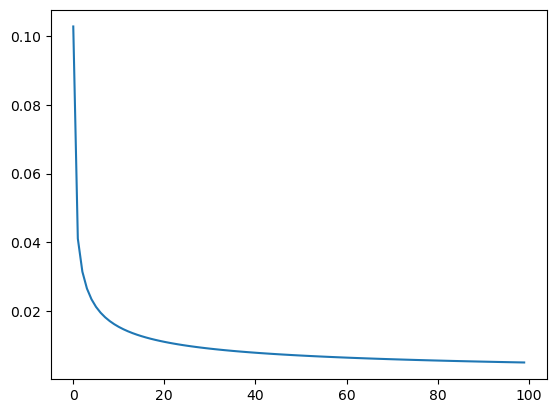

In [6]:
# Temporary pre-powerlaw testing coe
x0 = 0.001
d1 = p0
N=100
myrange=(x0,1)
bins = np.linspace(myrange[0], myrange[1], N+1)
prob_masses = np.exp(d1(bins[:-1]))+np.exp(d1(bins[1:]))
plt.plot(prob_masses/np.sum(prob_masses))
d1(x0)

In [7]:
out1 = nop.run_model(**input)

print(f"Number of events: {out1['N_events']}")

/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:253: RuntimeWarning: invalid value encountered in divide
  ppd_world_out = ppd_world_out[0] / np.sum(
/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:165: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jens/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:165: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


Number of events: 20023


## Data analysis

After simulating the network with $h=1, r=0$ (meaning nodes communicating with the central node only), some simple analysis steps follow.



In [8]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [9]:
for i in out1.keys():
   print(i)


nodes
G
beliefs
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


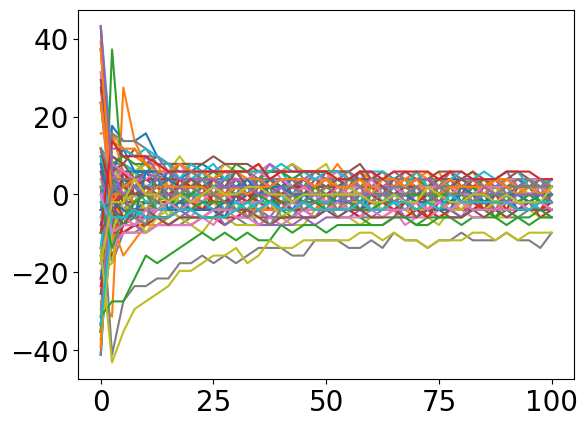

In [10]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(
    input["t0"],
    input["t_max"]+input["t_sample"],
    input["t_sample"]
)
for i in range(len(mu_arr.T)):
    
    plt.plot(
        x, mu_arr.T[i]
    )


#### Data analysis 2

In [11]:
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
lin_dis.shape

(41, 2, 100)

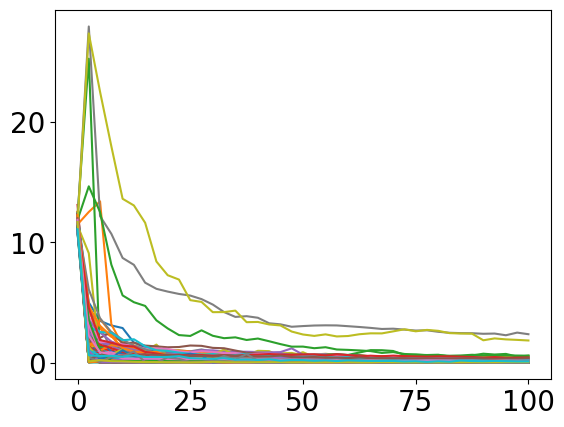

In [12]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, 1])

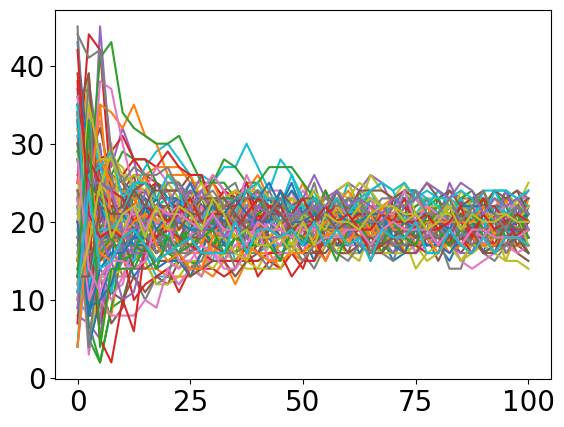

In [ ]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 1, i])

In [13]:
arr = np.array(out1["p_distances"])
arr.shape
(arr[-1, 0, 1, :] ** 2).mean()

8.458285274894273

In [14]:
arr2 = np.array(out1["kl_divs"])
arr2.shape

(41, 100, 2)

In [15]:
np.array(out1["mu_nodes"]).shape

(41, 100)